# Setup

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.transform
import skimage.io
import skimage
from util import utils

## Loading all the images

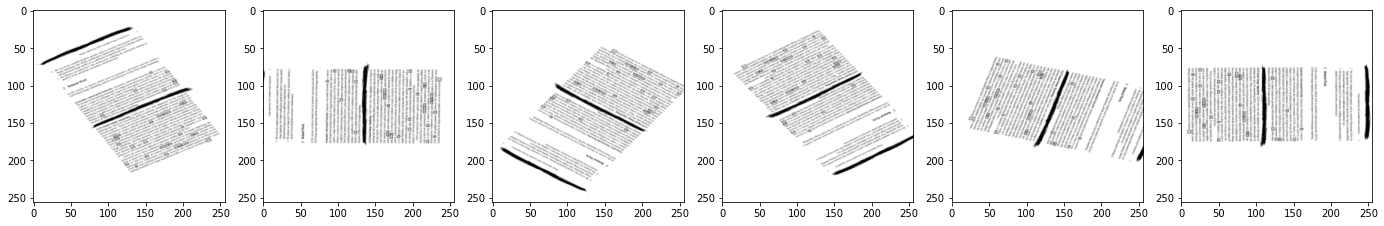

In [23]:
pages = [1,2,4,6,7,8]
images = [utils.read_im(utils.image_input_dir.joinpath(f"page{i}.png")) for i in pages]
cols, rows, size = len(images), 1, 4
plt.figure(figsize=(cols*size, rows*size))   
for i in range(len(images)):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(images[i], cmap="gray")

## Function that rotates a single image using its binary

In [24]:
def rotate_image(binary_image, image):
    assert binary_image.dtype == np.bool, f"Image is not Binary"
    # Find angle from binary image
    angles, distances = utils.find_angle(binary_image)
    angle = 0
    if len(angles) > 0:
        angle = angles[0] * 180 / np.pi
        
    hough_image = utils.create_hough_line_image(image, angles, distances)
    rotated_image = skimage.transform.rotate(image, angle, cval=image.max())
    
    return rotated_image, hough_image, angle

## Function that rotates a list of images

In [25]:
def rotate_images(binary_images: list, images: list):
    assert len(binary_images) == len(images), "Must have an image for each binary image"
    rotated_images, hough_images, angles = [], [], []
    for i in range(len(images)):
        rotated_image, hough_image, angle = rotate_image(binary_images[i], images[i])
        rotated_images.append(rotated_image)
        hough_images.append(hough_image)
        angles.append(angle)
    return rotated_images, hough_images, angles

# Task 4d
Now we will create a function to automatically find the rotation of scanned documents, such that we can align the text along the horizontal axis.

You will use the frequency domain to extract a binary image which draws a rough line describing the rotation of each document. From this, we can use a hough transform to find a straight line intersecting most of the points in the binary image. When we have this line, we can easily find the rotation of the line and the document.

Your task is to generate the binary image by using the frequency spectrum. 

In [26]:
TRESHOLD = 5 # 0 is black, 255 is white

def create_binary_fft(image: np.array):
    binary_image = np.zeros_like(image, dtype=np.bool)
    
    fft = np.fft.fft2(image)
    fft = np.fft.fftshift(fft)
    fft = utils.magnitude(fft)
    fft = np.log(fft + 1)
    
    x_max, y_max = image.shape
    for x in range(x_max):
        for y in range(y_max):
            if(TRESHOLD < fft[x, y]):
                binary_image[x, y] = 1
    
    return binary_image

## Create the binary images and rotate

In [27]:
binary_images = [create_binary_fft(image) for image in images]
rotated_images, hough_images, angles = rotate_images(binary_images, images)

print("| Page\t| Angle \t|") # formatted for easy copy-paste to report
print("| :--:\t| ----: \t|")
for i, angle in enumerate(angles):
    print(f"| {pages[i]}\t| {angle:.2f} \t|")

| Page	| Angle 	|
| :--:	| ----: 	|
| 1	| -21.81 	|
| 2	| 90.00 	|
| 4	| 26.82 	|
| 6	| -25.32 	|
| 7	| -67.44 	|
| 8	| 90.00 	|


## Plot the original, binary, hough and rotated images in a grid

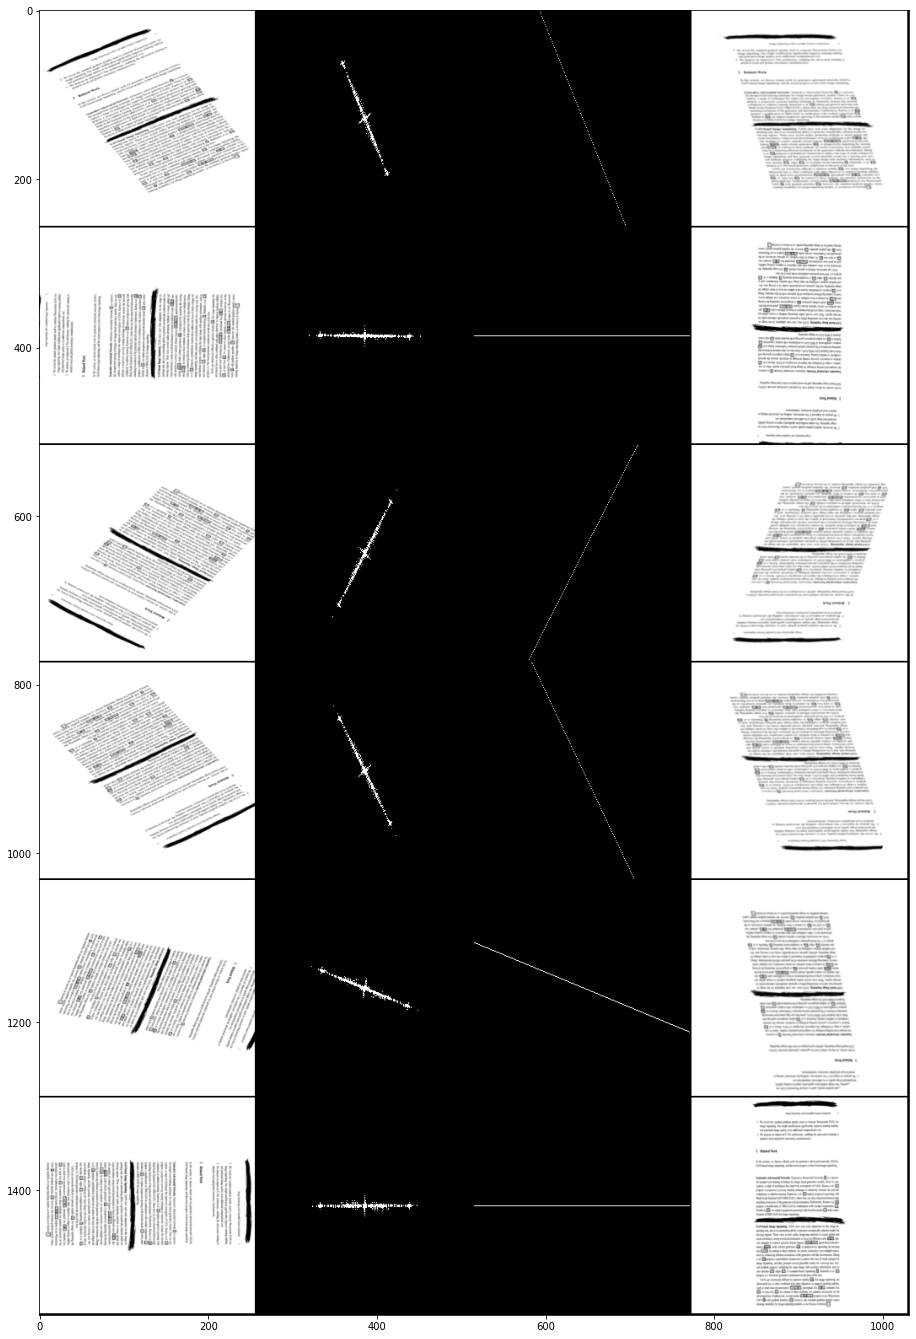

In [28]:
plt.figure(figsize=(size*4, size*6))    
images_to_visualize = []

for i in range(len(images)):
    images_to_visualize.extend([images[i], binary_images[i], hough_images[i], rotated_images[i]])

image = utils.np_make_image_grid(images_to_visualize, nrow=len(images))
plt.tight_layout()
plt.imshow(image, cmap="gray")
utils.save_im("task4d.png", image)